# Load Modules and define paths

In [1]:
%load_ext autoreload
%autoreload 2
from fastai.tabular import *
from sklearn.ensemble import RandomForestClassifier
import pandas_profiling
path='.'
file = path + '/kag_risk_factors_cervical_cancer.csv'

# Summary Statistics

In [2]:
full_data = pd.read_csv(file)
full_data.describe()

Age  STDs: Number of diagnosis   Dx:Cancer      Dx:CIN  \
count  858.000000                 858.000000  858.000000  858.000000   
mean    26.820513                   0.087413    0.020979    0.010490   
std      8.497948                   0.302545    0.143398    0.101939   
min     13.000000                   0.000000    0.000000    0.000000   
25%     20.000000                   0.000000    0.000000    0.000000   
50%     25.000000                   0.000000    0.000000    0.000000   
75%     32.000000                   0.000000    0.000000    0.000000   
max     84.000000                   3.000000    1.000000    1.000000   

           Dx:HPV          Dx  Hinselmann    Schiller    Citology      Biopsy  
count  858.000000  858.000000  858.000000  858.000000  858.000000  858.000000  
mean     0.020979    0.027972    0.040793    0.086247    0.051282    0.064103  
std      0.143398    0.164989    0.197925    0.280892    0.220701    0.245078  
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000

In [3]:
full_data.profile_report()

/home/vikram/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vikram/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vikram/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vikram/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vikram/anaconda3/envs/fastai/lib/python3.6

# Get rid of 'bad' Columns

In [6]:
full_data.replace('?', np.NaN, inplace=True)
bad_cols = ['STDs_Time_since_last_diagnosis', 'STDs_Time_since_first_diagnosis']
full_data.drop(bad_cols, axis = 1, inplace=True)

num_types = ['Number_of_sexual_partners', 'First_sexual_intercourse', 'Num_of_pregnancies', 
             'Smokes_(packs/year)',  'Smokes_(years)', 'Hormonal_Contraceptives_(years)'  ]
for i in num_types:
    full_data[i] = full_data[i].astype(float)

In [7]:
from sklearn.model_selection import train_test_split

# Get the data ready 

In [8]:
procs = [FillMissing, Categorify, Normalize]
XLabels = full_data.columns[:-1]
YLabels = ['Biopsy']
X = full_data[XLabels]
Y = full_data[YLabels]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y , random_state = 1, test_size = 0.2, stratify = Y) 

In [9]:
num_cols = ['Age',
           'STDs_Number_of_diagnosis', 'Number_of_sexual_partners', 'First_sexual_intercourse', 'Num_of_pregnancies', 
             'Smokes_(packs/year)',  'Smokes_(years)', 'Hormonal_Contraceptives_(years)']
cat_names = list(set(XLabels) - set(num_cols))
dep_var = 'Biopsy'

In [11]:
df = pd.concat([X_train, Y_train], axis =1)
valid_idx = range(len(df)-50, len(df))
embeddings={i : 20 for i in cat_names}

In [12]:
data = TabularDataBunch.from_df(path, df , dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names, test_df=X_test)
#data_test = TabularDataBunch.from_df(path, pd.concat([X_test, Y_test]) , dep_var, procs=procs, cat_names=cat_names)

# Build and train model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


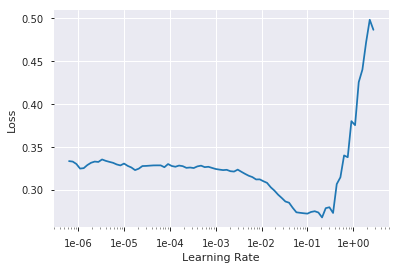

In [14]:
lr_find(learn)
learn.recorder.plot()

In [13]:
learn = tabular_learner(data, layers=[20, 10], metrics=accuracy,emb_szs=embeddings)
learn.fit_one_cycle(15, 0.25e-2)

In [15]:
preds = learn.get_preds(DatasetType.Test)
preds = [np.argmax(i) for i in np.array(preds[0])]

# Try it on the test set

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds, Y_test)
print(f'Accuracy on the test set: {(cm[0,0]+cm[1,1])/(cm.sum().sum())}')
print('--------')
print(cm)

Accuracy on the test set: 0.9534883720930233
--------
[[154   1]
 [  7  10]]


# RandomForestClassifier to understand feature importance

In [24]:
from sklearn.impute import SimpleImputer
m=RandomForestClassifier(n_jobs=-1, n_estimators = 100)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)
X_train_imp = imp.transform(X_train)

m.fit(X_train_imp, Y_train)
#m.score(X_train_imp, Y_train)

/home/vikram/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

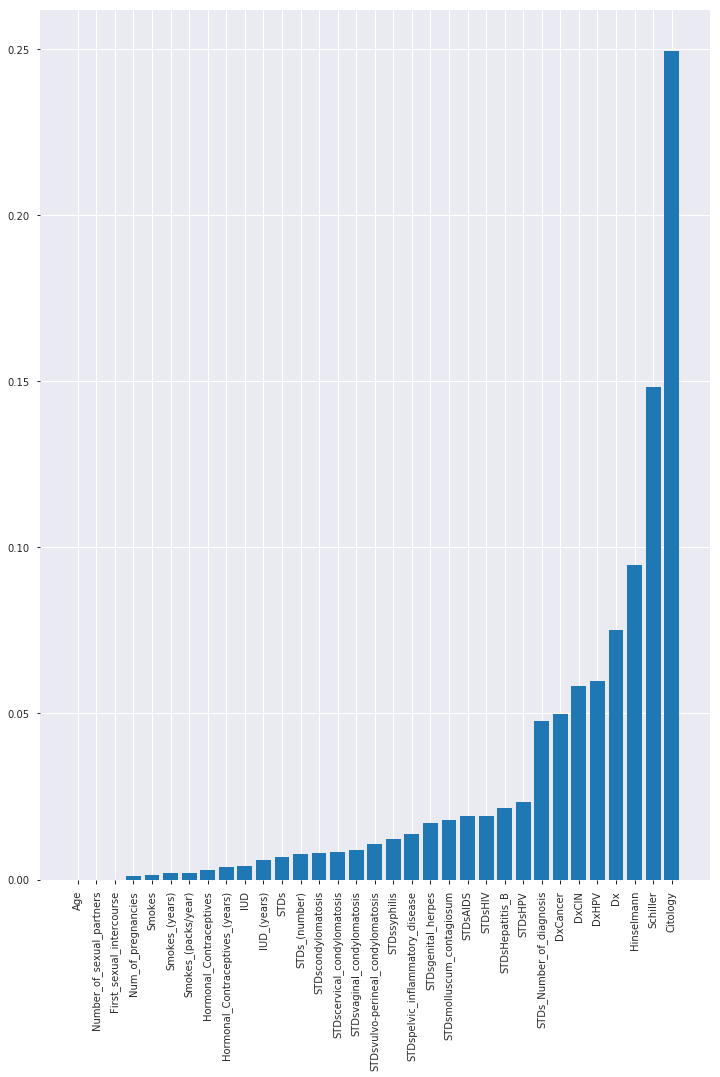

In [40]:
fig = plt.figure(figsize=(12, 16))
importance = m.feature_importances_
p = plt.bar(X_train.columns, np.sort(importance) )
xt= plt.xticks(rotation= 'vertical')
#plt.bar(np.arange(m.feature_importances_.shape[0]), m.feature_importances_ )

In [39]:
np.sort(importance)

array([0.      , 0.      , 0.      , 0.001061, 0.001446, 0.001911, 0.001912, 0.002977, 0.003867, 0.004071, 0.005757,
       0.006637, 0.007705, 0.007994, 0.008378, 0.009001, 0.010742, 0.012187, 0.013711, 0.016917, 0.01805 , 0.019071,
       0.019174, 0.021545, 0.023245, 0.04769 , 0.049916, 0.058123, 0.059696, 0.07514 , 0.094678, 0.148127, 0.249271])